In [1]:
!pip install git+https://github.com/karolzak/ipyplot

  Cloning https://github.com/karolzak/ipyplot to /tmp/pip-req-build-i58jr6rt
  Running command git clone -q https://github.com/karolzak/ipyplot /tmp/pip-req-build-i58jr6rt
  Created wheel for ipyplot: filename=ipyplot-1.1.1-py3-none-any.whl size=13352 sha256=abf6bf94eed1db2a666a4c9c08001e87eda5bbed1a10c202c5c837bae811623a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8viguy3r/wheels/38/16/9e/84faa6130b421551b63a041eef1aa81b95df2cc44d299f33b0
Successfully built ipyplot


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipyplot
from matplotlib_venn import venn2
from IPython.display import Image
%matplotlib inline
from IPython.display import HTML
import IPython
import torch
import cv2
from PIL import Image

In [3]:
DATA_DIR = "../input/atma11-dataset/"
os.listdir(DATA_DIR)

['atmaCup11_sample_submission.csv',
 'photos',
 'techniques.csv',
 'train.csv',
 'test.csv',
 'materials.csv',
 'ssl_200epo_light_ver9.pth']

In [4]:
train = pd.read_csv(DATA_DIR+"train.csv")
test = pd.read_csv(DATA_DIR+"test.csv")
materials = pd.read_csv(DATA_DIR+"materials.csv")
techniques = pd.read_csv(DATA_DIR+"techniques.csv")

In [5]:
np.random.seed(3)

def resize_fill(_img):
    _img = np.array(_img)
    w,h,c = _img.shape
    size = (224, 224)
    if w>h:
        left = int((w-h)/2)
        right = int((w-h)/2)
        top = 0
        bottom = 0
    elif h>w:
        top = int((h-w)/2)
        bottom = int((h-w)/2)
        left = 0
        right = 0
    else:
        left = 0
        right = 0
        top = 0
        bottom = 0
        
    _img = cv2.copyMakeBorder(
        _img,
        top=top,
        bottom=bottom,
        left=left,
        right=right,
        borderType=cv2.BORDER_REPLICATE,
        value=[0,0,0]
        )
        
    _img = cv2.resize(_img, size)
    return _img

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets, alpha):
    indices = torch.randperm(data.shape[0])
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.shape, lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.shape[-1] * data.shape[-2]))

    results = {
        'targets': targets,
        'shuffled_targets': shuffled_targets,
        'lam': lam
    }
    return data, results

def cutout(data, alpha):
    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.shape, lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = 0
    return data

def mixup(data, targets, alpha):
    """
    original mixup.
    """
    indices = torch.randperm(data.shape[0])
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    while True:
        lam = np.random.beta(alpha, alpha)
        if lam != 0 and lam != 1:
            break
    data = data * lam + shuffled_data * (1 - lam)

    results = {
        'targets': targets,
        'shuffled_targets': shuffled_targets,
        'lam': lam
    }
    return data, results

# train

In [6]:
train.shape

(3937, 4)

In [7]:
train.head()

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3937 entries, 0 to 3936
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   object_id      3937 non-null   object
 1   sorting_date   3937 non-null   int64 
 2   art_series_id  3937 non-null   object
 3   target         3937 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 123.2+ KB


<AxesSubplot:>

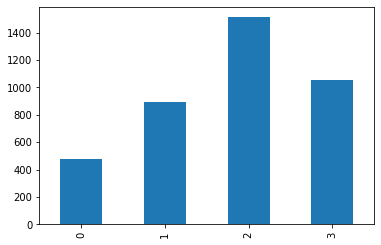

In [9]:
train.target.value_counts().sort_index().plot(kind="bar")

In [10]:
train.shape[0] == train.art_series_id.nunique()

False

In [11]:
train.art_series_id.value_counts()

607c22f5e66e8d50a298    9
6fb734ceff36fe2184b5    7
78db88c5ca6d7f6f4ac6    6
f8b88aff7f66a106ba3f    4
600db76c79a01bc40eb1    4
                       ..
1721c5254a83f037f135    1
9bd7a99dd72e529920b4    1
7ee2a942e05508e8f68b    1
cc8d7447bb3474eaf6b3    1
6a8b31d2026aeb8aff74    1
Name: art_series_id, Length: 3784, dtype: int64

In [12]:
train.sorting_date.value_counts()

1700    164
1600    117
1874     91
1773     81
1834     65
       ... 
1912      1
1930      1
1936      1
1938      1
1991      1
Name: sorting_date, Length: 401, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sorting_date'>

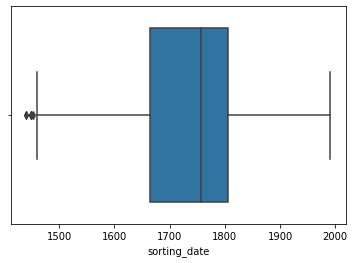

In [13]:
sns.boxplot(train.sorting_date)

In [14]:
train.sorting_date.value_counts().sort_index()

1440    2
1450    4
1453    1
1460    2
1470    3
       ..
1939    1
1943    2
1969    1
1983    2
1991    1
Name: sorting_date, Length: 401, dtype: int64

<AxesSubplot:xlabel='target', ylabel='sorting_date'>

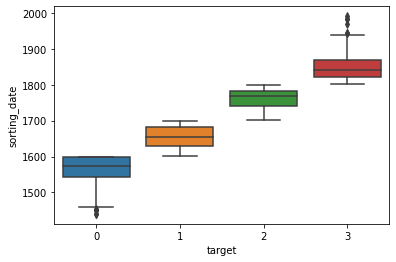

In [15]:
sns.boxplot(y="sorting_date", x="target", data=train)

# test

In [16]:
test.shape

(5919, 1)

In [17]:
test.head()

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3


# train vs test

In [18]:
set(train.object_id) & set(test.object_id)

set()

# materials

In [19]:
materials["object_id"].value_counts()

9010cbff4e7b59f89baa    6
cedc8287113cd835f074    5
a53a58dcdca1cc64c53a    5
549a09e1e90848fe0625    5
70054b1c0e48f97fb9bd    5
                       ..
4f3167780433e6391846    1
e129a9ef6dc6b6b9145c    1
6b22d2c196334aa1c885    1
6324a29a9b1f3fbb62ab    1
57b8c14d55ec0486724d    1
Name: object_id, Length: 3936, dtype: int64

In [20]:
materials.head()

,name,object_id
0,ink,002bff09b09998d0be65
1,paper,002bff09b09998d0be65
2,pencil,002bff09b09998d0be65
3,watercolor (paint),00309fb1ef05416f9c1f
4,paper,00309fb1ef05416f9c1f


In [21]:
materials.name.value_counts()

paper                          3746
ink                            1589
chalk                          1509
pencil                         1135
watercolor (paint)              543
deck paint                      130
graphite (mineral)              122
prepared paper                   91
parchment (animal material)      61
paint (coating)                  43
gouache (paint)                  38
oil paint (paint)                33
cardboard                        18
tracing paper                     8
linen (material)                  3
India ink (ink)                   2
leather                           2
wood (plant material)             1
varnish                           1
bristol board                     1
velvet (fabric weave)             1
metal                             1
zinc                              1
palm leaf (material)              1
gold leaf                         1
Name: name, dtype: int64

In [22]:
object_materials = materials.groupby("object_id")["name"].apply(list).reset_index(drop=False)
object_materials["name"] = object_materials["name"].apply(lambda x: sorted(x))
object_materials.head()

,object_id,name
0,002bff09b09998d0be65,"[ink, paper, pencil]"
1,00309fb1ef05416f9c1f,"[paper, watercolor (paint)]"
2,003a1562e97f79ba96dc,"[paper, pencil]"
3,004890880e8e7431147b,"[chalk, paper]"
4,00718c32602425f504c1,"[chalk, paper]"


In [23]:
print(object_materials["name"].astype(str).nunique(), object_materials["name"].astype(str).shape)
tmp = object_materials["name"].astype(str).value_counts()
tmp[tmp<4].shape #これで60クラスになるので最悪予測もできるか

124 (3936,)


(75,)

In [24]:
one_hot_mate = pd.get_dummies(materials, columns=['name'])
one_hot_mate = one_hot_mate.set_index('object_id')
one_hot_mate = one_hot_mate.sum(level=0).reset_index()

# 余分な列名削除
new_name = {}
for name in one_hot_mate:
    new_name[name] = name.replace('name_', '')

one_hot_mate = one_hot_mate.rename(columns=new_name)

unit_mate_df = train.merge(one_hot_mate, on='object_id', how='left')

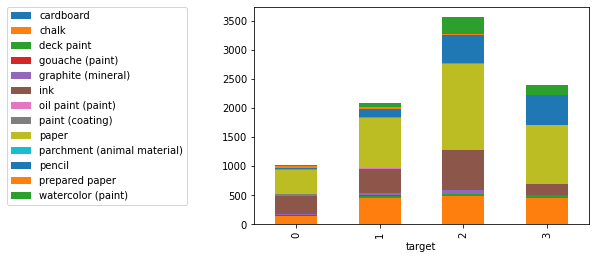

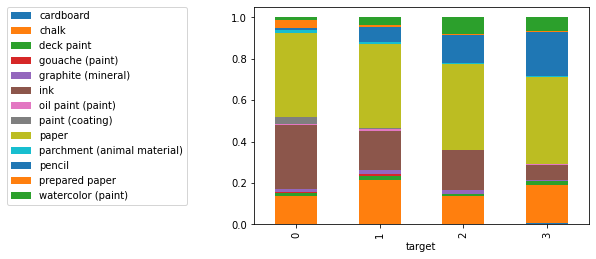

In [25]:
drop_list = ['tracing paper', 'linen (material)', 'India ink (ink)', 'leather', 'wood (plant material)', 'velvet (fabric weave)', 'palm leaf (material)', 'metal', 'zinc', 'varnish', 'gold leaf', 'bristol board']
grouped_unit_df = unit_mate_df.drop(['object_id', 'sorting_date', 'art_series_id'], axis=1)
grouped_unit_df = grouped_unit_df.drop(drop_list, axis=1)

grouped_unit_df = grouped_unit_df.groupby('target').sum()

grouped_unit_df.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right', borderaxespad=0, fontsize=10)

grouped_unit_df.div(grouped_unit_df.sum(axis=1), axis=0).plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right', borderaxespad=0, fontsize=10)

In [26]:
materials = materials.groupby(['object_id'])['name'].apply(lambda x: ','.join(x.astype(str))).reset_index()

In [27]:
materials.head()

,object_id,name
0,002bff09b09998d0be65,"ink,paper,pencil"
1,00309fb1ef05416f9c1f,"watercolor (paint),paper"
2,003a1562e97f79ba96dc,"pencil,paper"
3,004890880e8e7431147b,"chalk,paper"
4,00718c32602425f504c1,"paper,chalk"


Text(0.5, 1.0, 'object_id')

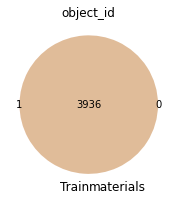

In [28]:
c = 'object_id'

fig, ax = plt.subplots(figsize=(5, 3))
venn2(
    subsets=(set(train[c].unique()), set(materials[c].unique())),
    set_labels=('Train', 'materials'),
    ax=ax
)
ax.set_title(c)

# technique

In [29]:
techniques.head()

,name,object_id
0,pen,002bff09b09998d0be65
1,brush,00309fb1ef05416f9c1f
2,counterproof,004890880e8e7431147b
3,brush,007f5e3620b458d77212
4,brush,00bf812ffe8a62d45661


In [30]:
techniques.object_id.value_counts()

6324a29a9b1f3fbb62ab    5
5bd8b13f4a4bb8bbf686    3
3f67d5b4fc193abb1485    3
a6f8d8abe041fc52fa69    3
78cc1a56bd23e4dd26ad    3
                       ..
d5bd5e7293b48a465eb8    1
b55f1ac9b346ca4e381a    1
421a3aea8be583849635    1
a3d4f005b71cb002bdbd    1
ee08c69705300bc5b925    1
Name: object_id, Length: 2566, dtype: int64

In [31]:
techniques.name.value_counts()

brush                   2179
pen                     1569
counterproof              17
chalk                      3
engraving                  2
snipping                   2
pencil                     2
letterpress printing       1
scoring                    1
sewing                     1
Name: name, dtype: int64

In [32]:
object_technique = techniques.groupby("object_id")["name"].apply(list).reset_index(drop=False)
object_technique["name"] = object_technique["name"].apply(lambda x: sorted(x))
object_materials.head()

,object_id,name
0,002bff09b09998d0be65,"[ink, paper, pencil]"
1,00309fb1ef05416f9c1f,"[paper, watercolor (paint)]"
2,003a1562e97f79ba96dc,"[paper, pencil]"
3,004890880e8e7431147b,"[chalk, paper]"
4,00718c32602425f504c1,"[chalk, paper]"


In [33]:
print(object_technique["name"].astype(str).nunique(), object_technique["name"].astype(str).shape)
tmp = object_technique["name"].astype(str).value_counts()
print(tmp[tmp<4].shape) #こちらはクラス数少ない
tmp.head()

21 (2566,)
(15,)


['brush', 'pen']      1158
['brush']              947
['pen']                398
['brush', 'brush']      22
['counterproof']        15
Name: name, dtype: int64

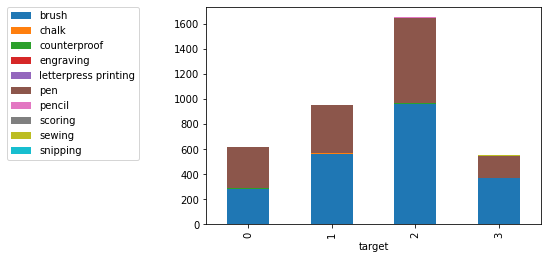

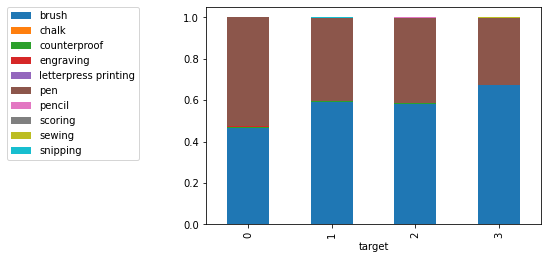

In [34]:
one_hot_tech = pd.get_dummies(techniques, columns=['name'])
one_hot_tech = one_hot_tech.set_index('object_id')
one_hot_tech = one_hot_tech.sum(level=0).reset_index()

# 余分な列名削除
new_name = {}
for name in one_hot_tech:
    new_name[name] = name.replace('name_', '')

one_hot_tech = one_hot_tech.rename(columns=new_name)

unit_tech_df = train.merge(one_hot_tech, on='object_id', how='left')
grouped_unit_df = unit_tech_df.drop(['object_id', 'sorting_date', 'art_series_id'], axis=1).groupby('target').sum()

grouped_unit_df.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right', borderaxespad=0, fontsize=10)

grouped_unit_df.div(grouped_unit_df.sum(axis=1), axis=0).plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right', borderaxespad=0, fontsize=10)

In [35]:
technique = techniques.groupby(['object_id'])['name'].apply(lambda x: ','.join(x.astype(str))).reset_index()

In [36]:
technique.shape

(2566, 2)

In [37]:
technique.head()

,object_id,name
0,002bff09b09998d0be65,pen
1,00309fb1ef05416f9c1f,brush
2,004890880e8e7431147b,counterproof
3,007f5e3620b458d77212,brush
4,00bf812ffe8a62d45661,"brush,pen"


Text(0.5, 1.0, 'object_id')

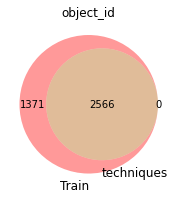

In [38]:
c = 'object_id'

fig, ax = plt.subplots(figsize=(5, 3))
venn2(
    subsets=(set(train[c].unique()), set(techniques[c].unique())),
    set_labels=('Train', 'techniques'),
    ax=ax
)
ax.set_title(c)

# image

In [39]:
plots = train[train.target == 1].head(30)['object_id'].map(lambda x:DATA_DIR+'photos/'+x+'.jpg').values
ipyplot.plot_images(plots, max_images=10, img_width=100)

# data augmentation

In [40]:
targets = train.target.values
data = train['object_id'].map(lambda x:resize_fill(cv2.imread(DATA_DIR+'photos/'+x+'.jpg'))).values
data_ = np.zeros([len(data), 224, 224, 3])
for i in range(len(data)):
    data_[i,:,:,:] = data[i]
data_ = data_.transpose(0, 3, 1, 2)
del data
targets.shape, data_.shape

((3937,), (3937, 3, 224, 224))

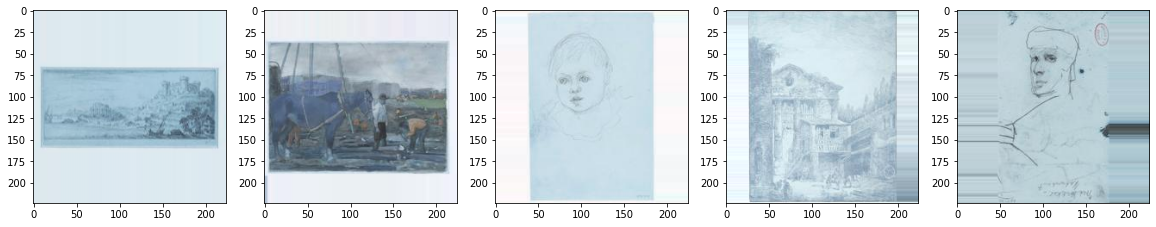

In [41]:
plt.figure(figsize=(20,5))

plt.subplot(1,5,1)
im_org = Image.fromarray(np.uint8(data_[0].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,2)
im_org = Image.fromarray(np.uint8(data_[1].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,3)
im_org = Image.fromarray(np.uint8(data_[2].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,4)
im_org = Image.fromarray(np.uint8(data_[3].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,5)
im_org = Image.fromarray(np.uint8(data_[4].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

# cutmix

In [42]:
alpha = 0.5
org = data_.copy()
cutmix_data, _ = cutmix(org[:5], targets[:5], alpha)
del org

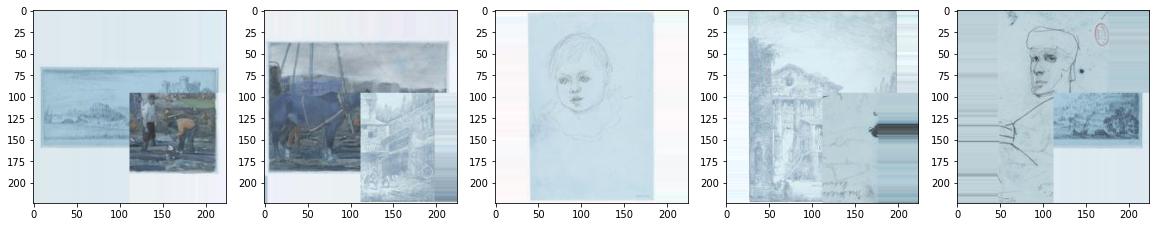

In [43]:
plt.figure(figsize=(20,5))

plt.subplot(1,5,1)
im_org = Image.fromarray(np.uint8(cutmix_data[0].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,2)
im_org = Image.fromarray(np.uint8(cutmix_data[1].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,3)
im_org = Image.fromarray(np.uint8(cutmix_data[2].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,4)
im_org = Image.fromarray(np.uint8(cutmix_data[3].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,5)
im_org = Image.fromarray(np.uint8(cutmix_data[4].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

# mixup

In [44]:
alpha = 0.3
org = data_.copy()
mixup_data, results = mixup(org[:5], targets[:5], alpha)
del org

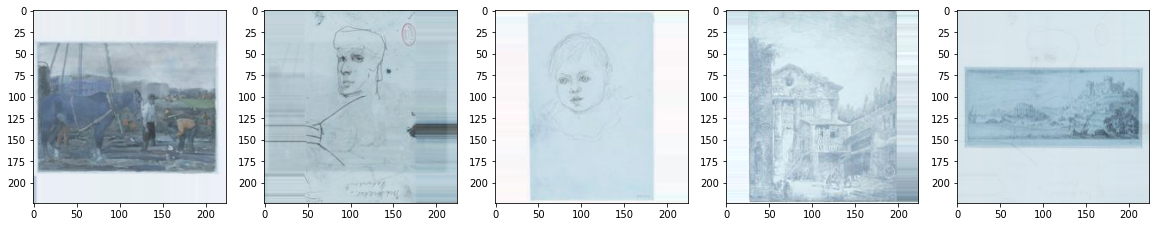

In [45]:
plt.figure(figsize=(20,5))

plt.subplot(1,5,1)
im_org = Image.fromarray(np.uint8(mixup_data[0].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,2)
im_org = Image.fromarray(np.uint8(mixup_data[1].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,3)
im_org = Image.fromarray(np.uint8(mixup_data[2].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,4)
im_org = Image.fromarray(np.uint8(mixup_data[3].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,5)
im_org = Image.fromarray(np.uint8(mixup_data[4].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

# cutout

In [46]:
alpha = 0.5
org = data_.copy()
cutout_data = cutout(org[:5], alpha)
del org

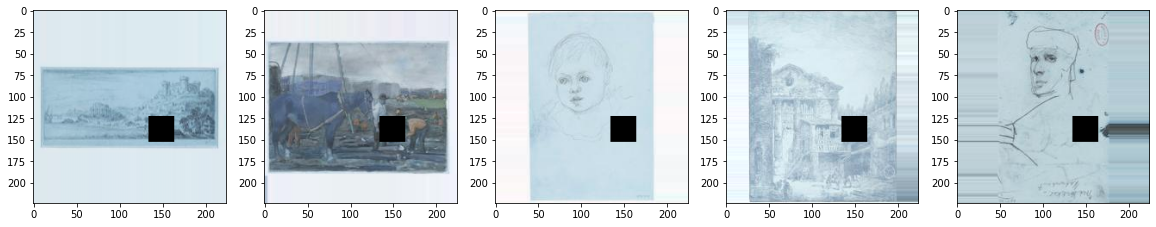

In [47]:
plt.figure(figsize=(20,5))

plt.subplot(1,5,1)
im_org = Image.fromarray(np.uint8(cutout_data[0].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,2)
im_org = Image.fromarray(np.uint8(cutout_data[1].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,3)
im_org = Image.fromarray(np.uint8(cutout_data[2].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,4)
im_org = Image.fromarray(np.uint8(cutout_data[3].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

plt.subplot(1,5,5)
im_org = Image.fromarray(np.uint8(cutout_data[4].transpose(1, 2, 0)))
plt.imshow(im_org)
del im_org

- material, techniquesについては記載がないobject_idあり
- targetは確かにsorting_dateの値で別れている
- techniquesはbrush, penが大半、materialsではpaperがよく使われる